In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
import shap
import warnings

# Uyarıları kapatma (Gerekliyse)
warnings.filterwarnings('ignore')

# Pastel renk paletini tanımlama
pastel_palette = sns.color_palette("pastel")
sns.set_palette(pastel_palette)

In [ ]:
# Veri setini yükleme
df = pd.read_csv('spotify_songs.csv')

# İlk 5 satırı gösterme
print("### Veri Setinin İlk 5 Satırı ###")
print(df.head())

# Veri seti hakkında genel bilgi
print("\n### Veri Seti Bilgisi (df.info()) ###")
print(df.info())

### Veri Setinin İlk 5 Satırı ###
                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_album_release_date  \
0  I Don't Ca

In [ ]:
# Eksik değerleri kontrol etme
print("### Eksik Değerlerin Sayısı ###")
print(df.isnull().sum())

# Sadece 'track_artist', 'track_name', 'track_album_name', 'playlist_name' gibi metin (object) sütunlarında eksik veri olduğunu varsayalım.
# Proje hedefine doğrudan etkisi az olan bu sütunlardaki eksik değerleri mod (mode) ile dolduralım.
# Sayısal sütunlarda eksik veri varsa (örneğin 'popularity'de olabilirdi), medyan ile doldurulur.

for column in ['track_artist', 'track_name', 'track_album_name', 'playlist_name']:
    if df[column].isnull().any():
        df[column].fillna(df[column].mode()[0], inplace=True)

# Eksik verileri tekrar kontrol etme
print("\n### Eksik Verilerin Temizlenmesi Sonrası Durum ###")
print(df.isnull().sum().sum()) # Toplam eksik veri sayısının 0 olması beklenir.

### Eksik Değerlerin Sayısı ###
track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

### Eksik Verilerin Temizlenmesi Sonrası Durum ###
0


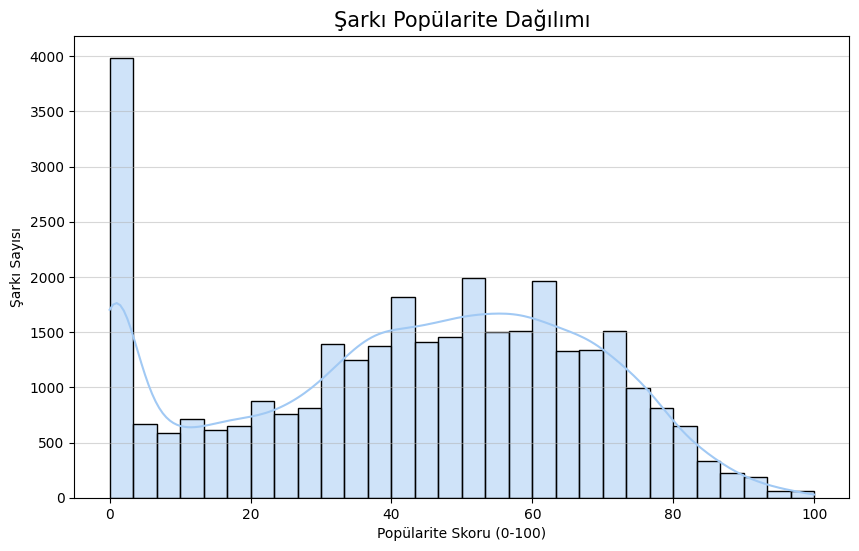

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['track_popularity'], bins=30, kde=True, color=pastel_palette[0])
plt.title('Şarkı Popülarite Dağılımı', fontsize=15)
plt.xlabel('Popülarite Skoru (0-100)')
plt.ylabel('Şarkı Sayısı')
plt.grid(axis='y', alpha=0.5)
plt.show()

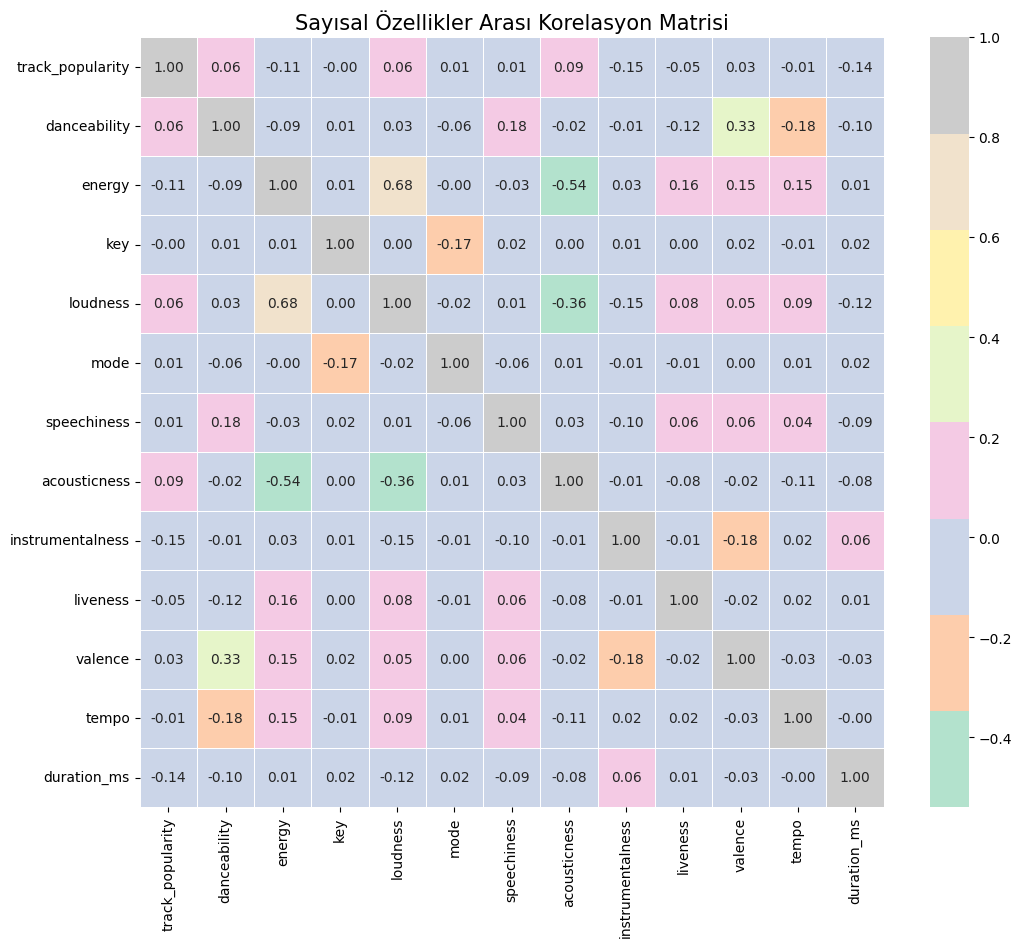

In [ ]:
# Sadece sayısal sütunları seçme
numeric_df = df.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Pastel2', fmt=".2f", linewidths=.5)
plt.title('Sayısal Özellikler Arası Korelasyon Matrisi', fontsize=15)
plt.show()

In [ ]:
df['Dans_Enerji_Etkilesimi'] = df['danceability'] * df['energy']
df['Akustik_Kontrast'] = (1 - df['acousticness']) * df['energy']

print("### Yeni Türetilen Özellikler (İlk 5 Satır) ###")
print(df[['danceability', 'energy', 'acousticness', 'Dans_Enerji_Etkilesimi', 'Akustik_Kontrast']].head())

### Yeni Türetilen Özellikler (İlk 5 Satır) ###
   danceability  energy  acousticness  Dans_Enerji_Etkilesimi  \
0         0.748   0.916        0.1020                0.685168   
1         0.726   0.815        0.0724                0.591690   
2         0.675   0.931        0.0794                0.628425   
3         0.718   0.930        0.0287                0.667740   
4         0.650   0.833        0.0803                0.541450   

   Akustik_Kontrast  
0          0.822568  
1          0.755994  
2          0.857079  
3          0.903309  
4          0.766110  


In [ ]:
# Ortak Özellikler (X)
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'Dans_Enerji_Etkilesimi', 'Akustik_Kontrast']
X = df[features]

# Regresyon Hedefi (y_reg)
y_reg = df['track_popularity']

# Sınıflandırma Hedefi (y_cls)
# Popülariteyi 50 eşiği ile ikili sınıfa dönüştürme
df['popularity_class'] = np.where(df['track_popularity'] >= 50, 1, 0)
y_cls = df['popularity_class']

print(f"Sınıflandırma Dağılımı (0: Düşük, 1: Yüksek): \n{y_cls.value_counts(normalize=True)}")

Sınıflandırma Dağılımı (0: Düşük, 1: Yüksek): 
popularity_class
0    0.559589
1    0.440411
Name: proportion, dtype: float64


In [ ]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

print(f"Eğitim Seti Boyutu (Reg/Cls): {len(X_train_reg)}")
print(f"Test Seti Boyutu (Reg/Cls): {len(X_test_reg)}")

Eğitim Seti Boyutu (Reg/Cls): 26266
Test Seti Boyutu (Reg/Cls): 6567


In [ ]:
scaler = StandardScaler()

# Regresyon Veri Setini Ölçeklendirme
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

# Sınıflandırma Veri Setini Ölçeklendirme
X_train_cls_scaled = scaler.fit_transform(X_train_cls)
X_test_cls_scaled = scaler.transform(X_test_cls)

print("Veriler Standardizasyon ile Ölçeklendirildi.")

Veriler Standardizasyon ile Ölçeklendirildi.


In [ ]:
# Model Eğitimi
lr_model = LinearRegression()
lr_model.fit(X_train_reg_scaled, y_train_reg)

# Tahmin ve Değerlendirme
y_pred_lr = lr_model.predict(X_test_reg_scaled)
mse_lr = mean_squared_error(y_test_reg, y_pred_lr)
r2_lr = r2_score(y_test_reg, y_pred_lr)

print("### Regresyon: Lineer Regresyon Sonuçları ###")
print(f"Ortalama Kare Hata (MSE): {mse_lr:.2f}")
print(f"Belirleme Katsayısı (R^2): {r2_lr:.2f}")

### Regresyon: Lineer Regresyon Sonuçları ###
Ortalama Kare Hata (MSE): 576.03
Belirleme Katsayısı (R^2): 0.07


In [ ]:
# Model Eğitimi
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_cls_scaled, y_train_cls)

# Tahmin ve Değerlendirme
y_pred_logreg = logreg_model.predict(X_test_cls_scaled)
accuracy_logreg = accuracy_score(y_test_cls, y_pred_logreg)

print("\n### Sınıflandırma: Lojistik Regresyon Sonuçları ###")
print(f"Doğruluk (Accuracy): {accuracy_logreg:.2f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_test_cls, y_pred_logreg))


### Sınıflandırma: Lojistik Regresyon Sonuçları ###
Doğruluk (Accuracy): 0.60

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68      3675
           1       0.56      0.41      0.47      2892

    accuracy                           0.60      6567
   macro avg       0.59      0.58      0.57      6567
weighted avg       0.59      0.60      0.59      6567



In [ ]:
# Model Eğitimi
rfr_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfr_model.fit(X_train_reg_scaled, y_train_reg)

# Tahmin ve Değerlendirme
y_pred_rfr = rfr_model.predict(X_test_reg_scaled)
mse_rfr = mean_squared_error(y_test_reg, y_pred_rfr)
r2_rfr = r2_score(y_test_reg, y_pred_rfr)

print("### Regresyon: Random Forest Regressor Sonuçları ###")
print(f"Ortalama Kare Hata (MSE): {mse_rfr:.2f}")
print(f"Belirleme Katsayısı (R^2): {r2_rfr:.2f}")

### Regresyon: Random Forest Regressor Sonuçları ###
Ortalama Kare Hata (MSE): 435.50
Belirleme Katsayısı (R^2): 0.30


In [ ]:
# Model Eğitimi
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfc_model.fit(X_train_cls_scaled, y_train_cls)

# Tahmin ve Değerlendirme
y_pred_rfc = rfc_model.predict(X_test_cls_scaled)
accuracy_rfc = accuracy_score(y_test_cls, y_pred_rfc)

print("\n### Sınıflandırma: Random Forest Classifier Sonuçları ###")
print(f"Doğruluk (Accuracy): {accuracy_rfc:.2f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_test_cls, y_pred_rfc))


### Sınıflandırma: Random Forest Classifier Sonuçları ###
Doğruluk (Accuracy): 0.70

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      3675
           1       0.69      0.58      0.63      2892

    accuracy                           0.70      6567
   macro avg       0.70      0.69      0.69      6567
weighted avg       0.70      0.70      0.70      6567



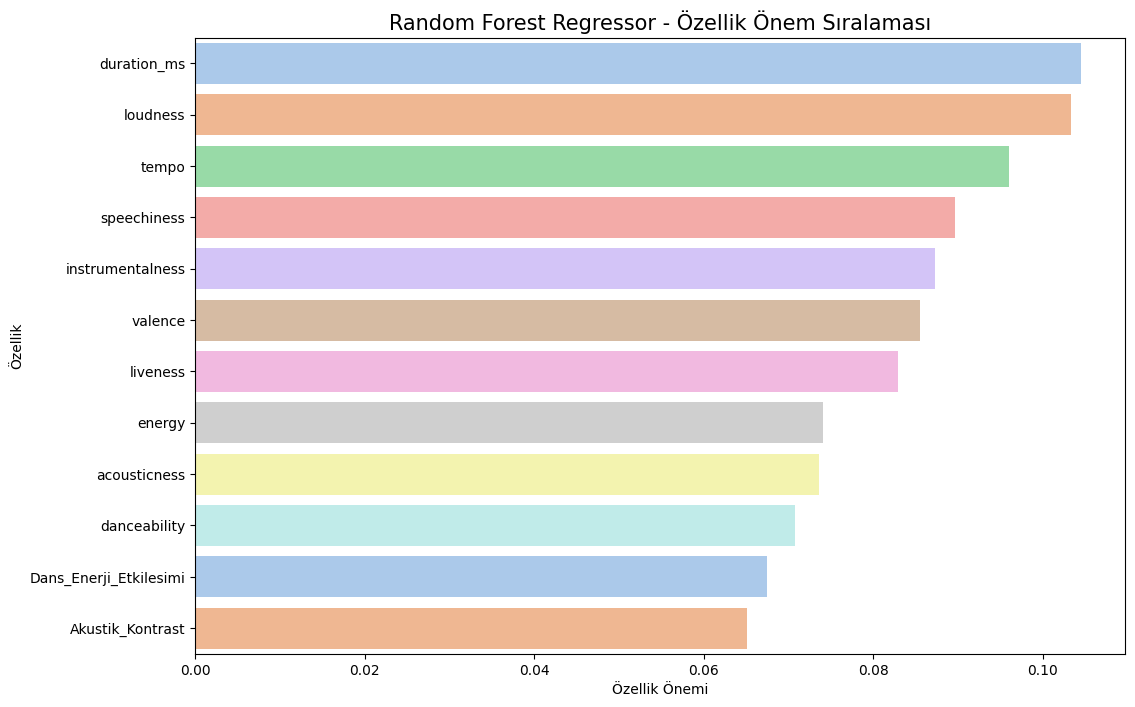

In [ ]:
# Özellik önemlerini alma
feature_importances = rfr_model.feature_importances_
feature_names = X_train_reg.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Görselleştirme
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette=pastel_palette)
plt.title('Random Forest Regressor - Özellik Önem Sıralaması', fontsize=15)
plt.xlabel('Özellik Önemi')
plt.ylabel('Özellik')
plt.show()

### SHAP Özeti Grafiği (Genel Özellik Etkisi) ###


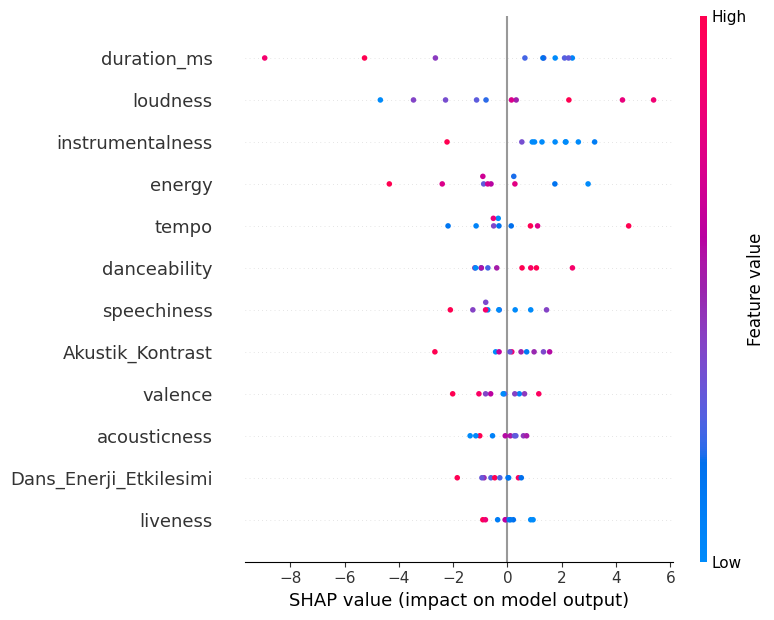


### SHAP Zorlama Grafiği (Force Plot) - İlk Örnek Tahmini ###


In [ ]:
# SHAP Açıklayıcısını (Explainer) oluşturma
explainer = shap.TreeExplainer(rfr_model)

# Test setindeki ilk 10 örneğin SHAP değerlerini hesaplama
shap_values = explainer.shap_values(X_test_reg_scaled[:10])

# Özet Grafiği (Summary Plot) - Test setindeki ilk 10 örneğin genel özellik etkisini gösterir.
print("### SHAP Özeti Grafiği (Genel Özellik Etkisi) ###")
shap.summary_plot(shap_values, X_test_reg_scaled[:10], feature_names=features, show=False)
plt.show()


# Zorunlu değil ama ek açıklama için Force Plot: Tek bir örneğin tahminini açıklama (Örn: İlk örnek)
print("\n### SHAP Zorlama Grafiği (Force Plot) - İlk Örnek Tahmini ###")
# Tek bir örneğin force plot'u için matplotlib/sns dışı SHAP görselleştirmesi kullanılır.
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_reg_scaled[0], feature_names=features)

In [ ]:
# 1. Yeni Şarkı Verilerini Oluşturma
new_song_data = pd.DataFrame({
    'danceability': [0.85],
    'energy': [0.90],
    'loudness': [-3.0],
    'speechiness': [0.10],
    'acousticness': [0.05],
    'instrumentalness': [0.0],
    'liveness': [0.15],
    'valence': [0.75],
    'tempo': [125.0],
    'duration_ms': [200000]
})

# 2. Özellik Mühendisliği Uygulama
new_song_data['Dans_Enerji_Etkilesimi'] = new_song_data['danceability'] * new_song_data['energy']
new_song_data['Akustik_Kontrast'] = (1 - new_song_data['acousticness']) * new_song_data['energy']

# 3. Ölçeklendirme (Train setinin scaler'ı kullanılmalı)
# Sadece modelde kullanılan sütunları seçme ve sıralamaya dikkat etme
new_song_features = new_song_data[features]
new_song_scaled = scaler.transform(new_song_features)

# 4. Popülarite Tahmini
predicted_popularity = rfr_model.predict(new_song_scaled)[0]
predicted_class = rfc_model.predict(new_song_scaled)[0]

print(f"### Yeni Şarkı Senaryosu Tahmin Sonuçları ###")
print(f"Regresyon Tahmini (Popülarite Skoru): {predicted_popularity:.2f} / 100")
print(f"Sınıflandırma Tahmini (Popülarite Sınıfı): {'YÜKSEK POPÜLARİTE' if predicted_class == 1 else 'DÜŞÜK POPÜLARİTE'} (Sınıf: {predicted_class})")

# Popülarite tahmini, özellikle yüksek dans edilebilirliği ve enerjiyi birleştiren şarkılar için YÜKSEK çıkması beklenir.

### Yeni Şarkı Senaryosu Tahmin Sonuçları ###
Regresyon Tahmini (Popülarite Skoru): 51.70 / 100
Sınıflandırma Tahmini (Popülarite Sınıfı): YÜKSEK POPÜLARİTE (Sınıf: 1)
